In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import re
import types
import pdb
import fastai 
from fastai.text import *
from fastai.text.data import *

In [3]:
import torch
import os
from torch.utils.data import *
from datetime import datetime

In [4]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, df = None, data_col = None, label_col = None, max_body_len = 200, max_label_len = 4):
        if df is None:
            return
        self.data_list = np.empty(len(df), dtype = np.object)
        self.labels_list = np.empty(len(df), dtype = np.object)
        for i in range(len(df)):
            df_row = df.iloc[i]
            if not df_row.isnull().values.any():
                dl = list(filter(None, df_row[1].lower().split(" ")))
                ll = list(filter(None, df_row[0].lower().split(" ")))
                if len(dl) <= max_body_len and len(ll) <= max_label_len:
                    self.data_list[i] = dl;        
                    self.labels_list[i] = ll;

        not_none_pos = self.data_list != np.array(None)
        self.data_list = self.data_list[not_none_pos]
        self.labels_list = self.labels_list[not_none_pos]
        self.data_vocab = Vocab(self.data_list)
        self.labels_vocab = Vocab(self.labels_list)
        for sen in range(len(self.data_list)):
            self.data_list[sen] = [0] + self.data_vocab.tokenize(self.data_list[sen]) + [2]
        for sen in range(len(self.labels_list)):
            self.labels_list[sen] = [0] + self.labels_vocab.tokenize(self.labels_list[sen]) + [2]
        return

    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        return self.data_list[idx], self.labels_list[idx]
                
    def save(self, path, name = None):       
        if name == None:
            name = str(len(self.data_list))
        name = 'dataset_' + name
        if not os.path.exists(path/name):
            os.makedirs(path/name) 
        with open(path/name/'data_list.pickle', 'wb') as f:
            pickle.dump(self.data_list, f)
        with open(path/name/'labels_list.pickle', 'wb') as f:
            pickle.dump(self.labels_list, f)
        with open(path/name/ 'data_itos.pickle', 'wb') as f:
            pickle.dump(self.data_vocab.itos, f)
        with open(path/name/ 'labels_itos.pickle', 'wb') as f:
            pickle.dump(self.labels_vocab.itos, f)
        
    @classmethod    
    def load(cls,path, name):
        tmp = cls()
        name = 'dataset_' + name
        with open(path/name/'data_list.pickle', 'rb') as f:
             tmp.data_list = pickle.load(f)
        with open(path/name/ 'labels_list.pickle', 'rb') as f:
             tmp.labels_list = pickle.load(f)
        with open(path/name/ 'data_itos.pickle', 'rb') as f:
             tmp.data_vocab = Vocab(itos = pickle.load(f))
        with open(path/name/ 'labels_itos.pickle', 'rb') as f:
             tmp.labels_vocab = Vocab(itos = pickle.load(f))
        return tmp
    
    def getTrainAndValidSubsets(self, val_perc=0.1):
        first_val_idx = int((1-val_perc)*len(self.data_list))
        return Subset(self,range(first_val_idx)), Subset(self,range(first_val_idx,len(self.data_list)))
            
            

In [5]:
class Vocab:
    def __init__(self, data = None, itos = None): 
        if itos is None:
            self.itos = Vocab.countWords(data)
            self.itos.insert(0, '_bos_')
            self.itos.insert(1, '_pad_')
            self.itos.insert(2, '_eos_')
            self.itos.insert(3, '_unk_')        
        else:
            self.itos = itos
        self.stoi = collections.defaultdict(lambda: 3, {v:k for k,v in enumerate(self.itos)})       
        
    @staticmethod       
    def countWords(sentences, min_freq = 2):  
        counter = {}  
        for sent in sentences:
            for word in sent:
                n = counter.get(word,0)
                counter[word] = n + 1        
        if min_freq > 1:
            counter = {w : c for w,c in counter.items() if c >= min_freq}         
        sorted_words =[k for k,v in sorted(counter.items(), key=lambda kv: -kv[1])]  
        return sorted_words
    
    def __len__(self):
        return len(self.itos)
    
    def tokenize(self, sentence:List[str])->List[int]:
        return [self.stoi[w] for w in sentence]
    
    def detokenize(self, numbers:List[int])->List[str]:
        return [self.itos[n] for n in numbers]

In [6]:
class LengthSampler(torch.utils.data.Sampler):
    def __init__(self, data_source, batch_size = 64, drop_last = False):
        self.drop_last = drop_last
        self.data_source = data_source
        self.bs = batch_size
        
    def __iter__(self):
        idxs = np.random.permutation(len(self.data_source))
        step = (len(self.data_source)//self.bs)
        sortedList = [sorted(idxs[i*step:i*step+step],key=lambda x: len(self.data_source[x][0]), reverse=True) for i in range(self.bs+1)]
        last_batch = sortedList[self.bs]
        sortedList = sortedList[0:self.bs]
        sortedList = [[sortedList[l][b] for l in range(self.bs)] for b in range(step) ] 
        if(not self.drop_last and not last_batch == []):
            sortedList += [last_batch] 
        return iter(sortedList)

    def __len__(self):
        return len(self.data_source)//self.bs if self.drop_last else int(math.ceil(len(self.data_source)/self.bs)) 

In [7]:
def toTensorCollate(batch):
#     print(batch)
    bs = len(batch)
    data_bacth = [t[0] for t in batch]
    labels_bacth = [t[1] for t in batch]
    
    data_tensor = torch.ones(bs, max([len(i) for i in data_bacth]), dtype= torch.long)
    for bi, body in enumerate(data_bacth):
        for ti, token in enumerate(body):
            data_tensor[bi, ti] = token
            
    labels_tensor = torch.ones(bs, max([len(i) for i in labels_bacth]), dtype= torch.long)
    for bi, label in enumerate(labels_bacth):
        for ti, token in enumerate(label):
            labels_tensor[bi, ti] = token
#     print(data_tensor)
#     print(data_tensor.shape)
        
    return data_tensor.transpose_(0,1), labels_tensor.transpose_(0,1)

In [8]:
path = Path("../base/")
ds_path = path/"dataset"

In [9]:
my_dataset = MyDataset.load(path, "2m_v2.0")
train_ds, valid_ds =  my_dataset.getTrainAndValidSubsets()

In [10]:
# sampler = LengthSampler(my_dataset,drop_last=True)
# dl = DataLoader(my_dataset,batch_sampler=sampler, collate_fn=toTensorCollate)
train_sampler = LengthSampler(train_ds, batch_size= 256, drop_last=False)
valid_sampler = LengthSampler(valid_ds, batch_size= 256, drop_last=False)
train_dl = DataLoader(train_ds,batch_sampler=train_sampler, collate_fn=toTensorCollate)
valid_dl = DataLoader(valid_ds,batch_sampler=valid_sampler, collate_fn=toTensorCollate)

In [5]:
df = pd.read_csv(filepath_or_buffer = path/"info.csv",sep =",",skipinitialspace=True,quotechar = "\"")
# print("Before cut: ", len(df))

# df = df.loc[[len(o.split(" ")) for o in df['MethodName']] <= 4]

# perc = np.percentile([len(o.) for o in df.Body],85)
# df = df.loc[[len(o) for o in df['Body']] < perc]
# print("After cut: ",len(df))
# # df = df.reset_index(drop=True)

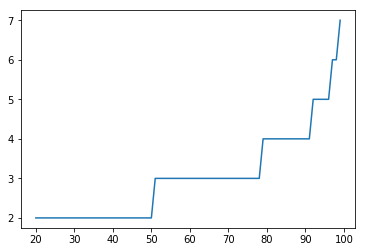

In [82]:
plt.plot(range(20,100),np.percentile([len(o.split(" ")) for o in df["MethodName"] if type(o) is str],range(20,100)))
# np.percentile([len(o) for o in df.MethodName],90)

In [85]:
# plt.plot(range(70,95),np.percentile([len(o.split(" ")) for o in df["Body"] if type(o) is str],range(70,95)))
np.percentile([len(o.split(" ")) for o in df["Body"]],85)

198.0

In [94]:
my_dataset = MyDataset(df, "Body", "MethodName")

In [113]:
len(my_dataset.labels_list)

1570359

In [11]:
print(len(train_ds),len(valid_ds), sum([len(train_ds),len(valid_ds)]))

1413323 157036 1570359


In [56]:
print(len(train_dl),len(valid_dl))

5521 614


In [50]:
i = 28
print(" ".join(my_dataset.labels_vocab.detokenize(my_dataset.labels_list[i])))
print(" ".join(my_dataset.data_vocab.detokenize(my_dataset.data_list[i])))

_bos_ clear _eos_
_bos_ /* * tagnewline * resets this element . tagnewline */ tagnewline @ override tagnewline public void tagmethodname ( ) { tagnewline this . input . set text ( " " ) ; tagnewline } _eos_


In [57]:
for b in iter(train_dl):
    print(b[0].shape)

torch.Size([202, 256])
torch.Size([202, 256])
torch.Size([202, 256])


KeyboardInterrupt: 

In [96]:
my_dataset.save(path, "2m_v2.0")

## Model

In [11]:
class Seq2SeqModel(nn.Module):
    def __init__(self, data_vocab_size,  labels_vocab_size, hidden_size= 400, num_layers = 3, enc_emb_len = 400, 
                 dec_emb_len = 400, out_seq_len = 6, device = None):
        super().__init__()
       
        self.data_vocab_size = data_vocab_size
        self.labels_vocab_size = labels_vocab_size
        self.enc_emb_len = enc_emb_len
        self.dec_emb_len = dec_emb_len        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.out_seq_len = out_seq_len
        
        if device is None:
            self.device = torch.device('cuda')
        else:
            self.device = device
        
        self.emb_enc = nn.Embedding(data_vocab_size, enc_emb_len, padding_idx=1)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.gru_enc = nn.GRU(enc_emb_len, hidden_size, num_layers=num_layers, dropout=0.1)
        self.out_enc = nn.Linear(hidden_size, dec_emb_len)       
        self.emb_dec = nn.Embedding(labels_vocab_size, dec_emb_len, padding_idx=1)
        self.gru_dec = nn.GRU(dec_emb_len, dec_emb_len, num_layers=num_layers, dropout=0.1)
        self.out_drop = nn.Dropout(0.15)
        self.out_linear = nn.Linear(dec_emb_len, labels_vocab_size)
        
    def forward(self, inp):
#         inp = inp.cuda()
#         print("inp size = ", inp.size(), ", is cuda = ",inp.is_cuda)       
#         pdb.set_trace()
        sl,bs = inp.shape
             
        emb = self.emb_enc(inp)
        emb = self.emb_enc_drop(emb)
#         must be SeqLen x ButchSize x EmbLenth
#         print("emb size = ", emb.size(),", is cuda = ", emb.is_cuda)
    
        h = self.initHidden(bs)
#         print("hiden size = ", h.size(),", is cuda = ", h.is_cuda)    
        
        rnn_out, h = self.gru_enc(emb, h)
#         print("rnn_out = ", rnn_out.size(),", is cuda = ", rnn_out.is_cuda)   
        
        h = self.out_enc(h)        
#         print("hiden size = ", h.size(), ", is cuda = ",h.is_cuda)   
        
        dec_inp = torch.zeros(bs,dtype= torch.long, device = self.device)
        res = []
        
        for i in range(self.out_seq_len):
            emb = self.emb_dec(dec_inp).unsqueeze(0)
#             print("emb_dec shape: ", emb.shape)
            dec_out, h = self.gru_dec(emb, h)
        
#             print("dec_out before linear shape: ", dec_out.shape)
            dec_out = self.out_linear(self.out_drop(dec_out[0]))
#             print("dec_out after linear shape: ", dec_out.shape)
            res.append(dec_out)
            dec_inp = dec_out.data.max(1)[1]      
#             if (dec_inp==1).all(): break
        return torch.stack(res)
    
    def initHidden(self, bs, bidir = False):
        first_dim = self.num_layers * 2 if bidir else self.num_layers 
        return torch.zeros(first_dim, bs, self.hidden_size, device=self.device)
    
    def save(self, path, name):
        name = 's2s_module_' + name
        if not os.path.exists(path/name):
            os.makedirs(path/name) 
        params = {
                "data_vocab_size":self.data_vocab_size, 
                "labels_vocab_size":self.labels_vocab_size,
                "hidden_size":self.hidden_size,
                "num_layers":self.num_layers,
                "enc_emb_len":self.enc_emb_len,  
                "dec_emb_len":self.dec_emb_len,   
                "out_seq_len":self.out_seq_len,
                "device":str(self.device)
        }
        with open(path/name/'params.pickle', 'wb') as f:
            pickle.dump(params, f)
        with open(path/name/'state_dict.pickle', 'wb') as f:
            pickle.dump(self.state_dict(), f)     
            
    @classmethod    
    def load(cls, path, name):        
        name = 's2s_module_' + name
        with open(path/name/'params.pickle', 'rb') as f:
            par = pickle.load(f)
        tmp = cls(par["data_vocab_size"],par["labels_vocab_size"],par["hidden_size"],
                  par["num_layers"],par["enc_emb_len"],par["dec_emb_len"],
                  par["out_seq_len"],torch.device(par["device"]))
        with open(path/name/'state_dict.pickle', 'rb') as f:
            tmp.load_state_dict(pickle.load(f))
        return tmp
    
    def to(self, dev):
        if isinstance(dev, str):            
            dev = torch.device(dev)
        self.device = dev
        super().to(dev)
        

In [12]:
@dataclass
class OneCycleScheduler():
    lr_max:float
    moms:Floats=(0.95,0.85)
    div_factor:float=25.
    pct_start:float=0.3

    def steps(self, *steps_cfg:StartOptEnd):
        "Build anneal schedule for all of the parameters."
        return [Stepper(step, n_iter, func=func)
                for (step,(n_iter,func)) in zip(steps_cfg, self.phases)]

    def on_train_begin(self, train_dl_length, opt, n_epochs:int = 1, **kwargs:Any)->None:
        "Initialize our optimization params based on our annealing schedule."
        n = train_dl_length * n_epochs
        a1 = int(n * self.pct_start)
        a2 = n-a1
        self.phases = ((a1, annealing_cos), (a2, annealing_cos))
        low_lr = self.lr_max/self.div_factor
        self.lr_scheds = self.steps((low_lr, self.lr_max), (self.lr_max, low_lr/1e4))
        self.mom_scheds = self.steps(self.moms, (self.moms[1], self.moms[0]))
        self.opt = opt
        self.opt.lr,self.opt.mom = self.lr_scheds[0].start,self.mom_scheds[0].start
        self.idx_s = 0

    def on_batch_end(self)->None:
        if self.idx_s >= len(self.lr_scheds): return True
        self.opt.lr = self.lr_scheds[self.idx_s].step()
        self.opt.mom = self.mom_scheds[self.idx_s].step()
        # when the current schedule is complete we move onto the next
        # schedule. (in 1-cycle there are two schedules)
        if self.lr_scheds[self.idx_s].is_done:
            self.idx_s += 1

In [13]:
def my_fit(model, optimiser, loss_func, train_dl, valid_dl,epochs = 1):
    sheduler = OneCycleScheduler(lr_max = optimiser.lr)
    dl_length = len(train_dl)
    sheduler.on_train_begin(dl_length, opt=optimiser )
    loss = None
    model.to("cuda")
       
    start_time = datetime.now()
    for epoch in range(epochs):
        model.train()
        print(f'Epoch = {epoch}')        
        for bi, (xb, yb) in enumerate(train_dl):   
            bs = xb.shape[1]
            xb = xb.cuda()
            yb = yb.cuda()
            ll = loss_batch(model, xb,yb,loss_func,optimiser).item()
            if loss is None:
                loss = ll
            else:
                loss = loss*0.98 + ll*0.02 
            sheduler.on_batch_end()
            if bi % 100 == 0:                
                print(f'{bi}/{dl_length}, loss {loss}, time passed {datetime.now() - start_time}')
        print('Validating...')
        valid_loss = validate(model, valid_dl, loss_func)
        print(f'validate loss: {valid_loss}, time passed {datetime.now() - start_time}')
        
        
def loss_batch(model:nn.Module, xb:Tensor, yb:Tensor, loss_func:OptLossFunc=None, opt:OptOptimizer=None)->Tuple[Union[Tensor,int,float,str]]:
    "Calculate loss and metrics for a batch, call out to callbacks as necessary."   
    opt.zero_grad()
    out = model(xb)   
    loss = loss_func(out, yb)
    loss.backward()
    opt.step()    
    return loss.detach().cpu()


In [14]:
def validate(model:nn.Module, valid_dl:DataLoader, loss_func:OptLossFunc=None, average=True)->Iterator[Tuple[Union[Tensor,int],...]]:
    "Calculate `loss_func` of `model` on `dl` in evaluation mode."
    model.eval()
    with torch.no_grad():
        val_losses = []
        for bi,(xb,yb) in enumerate(valid_dl):
            xb = xb.cuda()
            yb = yb.cuda()           
            out = model(xb)   
            loss = loss_func(out, yb)           
            loss.detach().cpu()
            val_losses.append(loss.detach().cpu())                   
        if average: return torch.mean(torch.stack(val_losses)).item()
        else:       return val_losses

In [15]:
def seq2seq_loss(input, target):
    sl,bs = target.size()
    sl_in,bs_in, num_classes = input.size()
    if sl>sl_in: input = F.pad(input, (0,0,0,0,0,sl-sl_in))
    input = input[:sl]
#     print("input shape: ", input.shape)
#     print("target shape: ", target.shape)
    input = input.contiguous()
    target = target.contiguous()
    return F.cross_entropy(input.view(-1,num_classes), target.view(-1))#, ignore_index=1)

In [16]:
def predict(model, dl, bn):
    model.eval()
    with torch.no_grad():
        for bi,(xb,yb) in enumerate(dl):        
            if not bi == bn: continue           
            y_pred = model(xb.cuda()).transpose(0,1)
            y_pred = y_pred.max(2)[1]
            yb = yb.transpose(0,1)
            for i, y in enumerate(yb):
                print(" ".join(my_dataset.labels_vocab.detokenize(y.tolist()[1:])))
                print(" ".join(my_dataset.labels_vocab.detokenize(y_pred[i].tolist()[1:])))            
                print()
            break

In [44]:
def count_accuracy(model, dl):
    s = 0
    c = 0
    model.eval()
    with torch.no_grad():
        for (xb, yb) in dl:
            y_pred = model(xb.cuda())
            y_pred = y_pred.max(2)[1]
            dif = ((yb[1:-1]) == (y_pred.cpu()[1:-1]))
            s += dif.sum().item()
            c += dif.numel()
    print(f"accuracy = {s/c}, ({s}/{c})")

In [17]:
s2s_model = Seq2SeqModel(len(my_dataset.data_vocab),len(my_dataset.labels_vocab), device= torch.device("cuda"))

In [67]:
validate(s2s_model,valid_dl,seq2seq_loss)

tensor(2.5494)

In [90]:
xb,yb = next(iter(valid_dl))      
y_pred = s2s_model(xb.cuda()).transpose(0,1)
yb = yb.transpose(0,1)
# for i, y in enumerate(yb):
#     print(" ".join(my_dataset.labels_vocab.detokenize(y.tolist())))
#      y_pred[i][]

In [92]:
y_pred = y_pred.max(2)[1]

In [94]:
y_pred.shape

torch.Size([256, 6])

In [23]:
predict(s2s_model, valid_dl,250)

add file _eos_ _pad_ _pad_
delete file _eos_ _pad_ _pad_

get parametric message _eos_ _pad_
get _eos_ _eos_ _pad_ _pad_

get query _eos_ _pad_ _pad_
get _eos_ _eos_ _pad_ _pad_

get bnd file properties _eos_
get properties _eos_ _pad_ _pad_

get type _eos_ _pad_ _pad_
get type _eos_ _pad_ _pad_

get address id _eos_ _pad_
get address _eos_ _pad_ _pad_

get calendar _eos_ _pad_ _pad_
get _eos_ _pad_ _pad_ _pad_

dynamic query _eos_ _pad_ _pad_
get query query _eos_ _pad_

main _eos_ _pad_ _pad_ _pad_
main _eos_ _pad_ _pad_ _pad_

assert update count _eos_ _pad_
assert update count _eos_ _pad_

gl get shaderiv _eos_ _pad_
gl get _eos_ _eos_ _pad_

write test output _eos_ _pad_
on output output _eos_ _pad_

get file entry _eos_ _pad_
get file entry _eos_ _pad_

get workflow task assignees _eos_
get task task task _eos_

assert update count _eos_ _pad_
assert update count _eos_ _pad_

apply _eos_ _pad_ _pad_ _pad_
write _eos_ _pad_ _pad_ _pad_

get script _eos_ _pad_ _pad_
get script _eos

In [41]:
count_accuracy(s2s_model,valid_dl)

accuracy = 0.7054398148148148, (659479/934848)


In [29]:
(a == c).sum()



tensor(5)

In [22]:
s2s_model.save(path, "4e")

In [19]:
s2s_model = Seq2SeqModel.load(path, "3e")

In [26]:
it = iter(train_dl)
next(it)[0].size()

torch.Size([26, 64])

In [149]:
def fakeCollate(tensorBatch):
    return tensorBatch
data_bunch = DataBunch(train_dl, valid_dl,collate_fn=fakeCollate)

opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [127]:
learn = Learner(db,s2s_model, loss_func = seq2seq_loss)

In [128]:
learn.lr_find()

inp size =  torch.Size([26, 64]) , is cuda =  False
emb size =  torch.Size([64, 26, 400]) , is cuda =  False
hiden size =  torch.Size([3, 26, 400]) , is cuda =  False
rnn_out =  torch.Size([64, 26, 400]) , is cuda =  False
hiden size =  torch.Size([3, 26, 400]) , is cuda =  False
emb_dec shape:  torch.Size([1, 26, 400])
dec_out before linear shape:  torch.Size([1, 26, 400])
dec_out after linear shape:  torch.Size([26, 5859])
emb_dec shape:  torch.Size([1, 26, 400])
dec_out before linear shape:  torch.Size([1, 26, 400])
dec_out after linear shape:  torch.Size([26, 5859])
emb_dec shape:  torch.Size([1, 26, 400])
dec_out before linear shape:  torch.Size([1, 26, 400])
dec_out after linear shape:  torch.Size([26, 5859])
emb_dec shape:  torch.Size([1, 26, 400])
dec_out before linear shape:  torch.Size([1, 26, 400])
dec_out after linear shape:  torch.Size([26, 5859])
emb_dec shape:  torch.Size([1, 26, 400])
dec_out before linear shape:  torch.Size([1, 26, 400])
dec_out after linear shape:  to

RuntimeError: invalid argument 2: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Call .contiguous() before .view(). at c:\a\w\1\s\tmp_conda_3.7_183942\conda\conda-bld\pytorch_1549564939537\work\aten\src\th\generic/THTensor.cpp:213

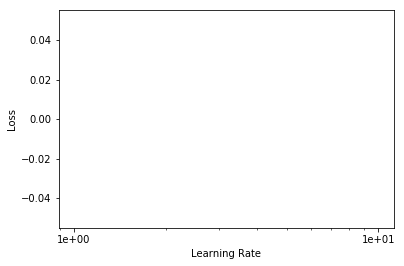

In [79]:
learn.recorder.plot(skip_end=0)

In [80]:
learn.fit_one_cycle(1, 1e-4)

AttributeError: 'int' object has no attribute 'to'

In [108]:
class MyFDataBunch():
    def __init__(self, train_dl, valid_dl):
        self.train_dl = train_dl
        self.valid_dl = valid_dl
        self.path = path/"TEMP"
        self.device = torch.device("cpu")
        self.loss_func = seq2seq_loss

In [130]:
db = MyFDataBunch(train_dl, valid_dl)

In [18]:
for b in train_dl:
    print(type(b))
    print(len(b))
    break

<class 'tuple'>
2


In [20]:
lr = 5e-5 
opt_wraper = OptimWrapper(optim.Adam(s2s_model.parameters(),lr))

In [21]:
my_fit(s2s_model, opt_wraper,seq2seq_loss,train_dl,valid_dl,epochs= 2)

Epoch = 0
0/5521, loss 2.27272891998291, time passed 0:00:04.629807
100/5521, loss 1.9609993554477514, time passed 0:01:25.015640
200/5521, loss 1.8239554913799254, time passed 0:02:40.726810
300/5521, loss 1.7890418178829535, time passed 0:03:52.123799
400/5521, loss 1.699055166583032, time passed 0:05:06.186346
500/5521, loss 1.7181610283844564, time passed 0:06:14.385141
600/5521, loss 1.6334904621388635, time passed 0:07:17.723165
700/5521, loss 1.6498898698202036, time passed 0:08:15.316735
800/5521, loss 1.6501357860429406, time passed 0:09:10.208136
900/5521, loss 1.5962798049554414, time passed 0:10:02.724258
1000/5521, loss 1.527691578896733, time passed 0:10:54.471683
1100/5521, loss 1.5335329850892556, time passed 0:11:41.796353
1200/5521, loss 1.516336408984347, time passed 0:12:31.304004
1300/5521, loss 1.5302808921924156, time passed 0:13:18.700047
1400/5521, loss 1.5480749521229777, time passed 0:14:01.068540
1500/5521, loss 1.550312194542577, time passed 0:14:41.932268


In [29]:
str(torch.device("cpu"))

'cpu'

## Bidirectional

In [21]:
class Seq2SeqTorchBidirModel(Seq2SeqModel):
    def __init__(self, data_vocab_size,  labels_vocab_size, hidden_size= 400, num_layers = 3, enc_emb_len = 400, 
                 dec_emb_len = 400, out_seq_len = 6, device = None):
        nn.Module.__init__(self)
       
        self.data_vocab_size = data_vocab_size
        self.labels_vocab_size = labels_vocab_size
        self.enc_emb_len = enc_emb_len
        self.dec_emb_len = dec_emb_len        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.out_seq_len = out_seq_len
        
        if device is None:
            self.device = torch.device('cuda')
        else:
            self.device = device
        
        self.emb_enc = nn.Embedding(data_vocab_size, enc_emb_len, padding_idx=1)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.gru_enc = nn.GRU(enc_emb_len, hidden_size, num_layers=num_layers, dropout=0.1, bidirectional = True)
        self.out_enc = nn.Linear(hidden_size*2, dec_emb_len)       
        self.emb_dec = nn.Embedding(labels_vocab_size, dec_emb_len, padding_idx=1)
        self.gru_dec = nn.GRU(dec_emb_len, dec_emb_len, num_layers=num_layers, dropout=0.1)
        self.out_drop = nn.Dropout(0.15)
        self.out_linear = nn.Linear(dec_emb_len, labels_vocab_size)
        
    def forward(self, inp):
        sl,bs = inp.shape
             
        emb = self.emb_enc(inp)
        emb = self.emb_enc_drop(emb)    
        h = self.initHidden(bs, bidir = True)
        rnn_out, h = self.gru_enc(emb, h)
#     h_n.view(num_layers, num_directions, batch, hidden_size)
#         print("h size = ", h.size(), ", is cuda = ",h.is_cuda)       
#         h = h.view(self.num_layers, 2, bs, self.hidden_size)
#         print("h size = ", h.size(), ", is cuda = ",h.is_cuda)
        h = torch.cat([h[0:h.size(0):2], h[1:h.size(0):2]], dim=2)
#         print("h size = ", h.size(), ", is cuda = ",h.is_cuda)
        h = self.out_enc(h)
#         print("h size = ", h.size(), ", is cuda = ",h.is_cuda)
        dec_inp = torch.zeros(bs,dtype= torch.long, device = self.device)
        res = []
        
        for i in range(self.out_seq_len):
            emb = self.emb_dec(dec_inp).unsqueeze(0)
            dec_out, h = self.gru_dec(emb, h)

            dec_out = self.out_linear(self.out_drop(dec_out[0]))
            res.append(dec_out)
            dec_inp = dec_out.data.max(1)[1] 
        return torch.stack(res)

In [22]:
s2s_tbi_model = Seq2SeqTorchBidirModel(len(my_dataset.data_vocab),len(my_dataset.labels_vocab), device= torch.device("cuda"))

In [21]:
s2s_tbi_model.to("cuda")
xb,yb = next(iter(train_dl))
y_pred = s2s_tbi_model(xb.cuda()).transpose(0,1)
yb = yb.transpose(0,1)

h size =  torch.Size([6, 256, 400]) , is cuda =  True
h size =  torch.Size([3, 256, 800]) , is cuda =  True
h size =  torch.Size([3, 256, 400]) , is cuda =  True


In [23]:
lr = 1e-4 
opt_wraper = OptimWrapper(optim.Adam(s2s_tbi_model.parameters(),lr))
my_fit(s2s_tbi_model, opt_wraper,seq2seq_loss,train_dl,valid_dl,epochs= 2)

Epoch = 0
0/11042, loss 9.877474784851074, time passed 0:00:02.812506
100/11042, loss 4.7461216573754434, time passed 0:01:09.124453
200/11042, loss 3.4117492290438713, time passed 0:02:16.013377
300/11042, loss 3.145407561237915, time passed 0:03:22.464446
400/11042, loss 3.092707936198532, time passed 0:04:26.605234
500/11042, loss 3.0448964761138884, time passed 0:05:27.215568
600/11042, loss 3.0213189933712274, time passed 0:06:25.749489
700/11042, loss 2.8913255101677295, time passed 0:07:22.737253
800/11042, loss 2.851208225545426, time passed 0:08:18.122909
900/11042, loss 2.8607755604231064, time passed 0:09:12.208356
1000/11042, loss 2.825176573061855, time passed 0:10:05.164592
1100/11042, loss 2.7689145349511755, time passed 0:10:56.417623
1200/11042, loss 2.663449697756338, time passed 0:11:46.265885
1300/11042, loss 2.6001966937797185, time passed 0:12:33.740174
1400/11042, loss 2.6477703317510692, time passed 0:13:20.260022
1500/11042, loss 2.640591507180195, time passed 

KeyboardInterrupt: 

In [17]:
class Seq2SeqMyBidirModel(Seq2SeqModel):
    def __init__(self, data_vocab_size,  labels_vocab_size, hidden_size= 400, num_layers = 3, enc_emb_len = 400, 
                 dec_emb_len = 400, out_seq_len = 6, device = None):
        nn.Module.__init__(self)
       
        self.data_vocab_size = data_vocab_size
        self.labels_vocab_size = labels_vocab_size
        self.enc_emb_len = enc_emb_len
        self.dec_emb_len = dec_emb_len        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.out_seq_len = out_seq_len
        
        if device is None:
            self.device = torch.device('cuda')
        else:
            self.device = device
        
        self.emb_enc = nn.Embedding(data_vocab_size, enc_emb_len, padding_idx=1)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.f_gru_enc = nn.GRU(enc_emb_len, hidden_size, num_layers=num_layers, dropout=0.1)
        self.b_gru_enc = nn.GRU(enc_emb_len, hidden_size, num_layers=num_layers, dropout=0.1)
        self.out_enc = nn.Linear(hidden_size*2, dec_emb_len)       
        self.emb_dec = nn.Embedding(labels_vocab_size, dec_emb_len, padding_idx=1)
        self.gru_dec = nn.GRU(dec_emb_len, dec_emb_len, num_layers=num_layers, dropout=0.1)
        self.out_drop = nn.Dropout(0.15)
        self.out_linear = nn.Linear(dec_emb_len, labels_vocab_size)
        
    def forward(self, inp):
        sl,bs = inp.shape
             
        emb = self.emb_enc(inp)
        emb = self.emb_enc_drop(emb)    
        h = self.initHidden(bs)
        rnn_out, h_f = self.f_gru_enc(emb, h)
        h = self.initHidden(bs)
        rnn_out, h_b = self.b_gru_enc(emb.flip(0), h)
#     h_n.view(num_layers, num_directions, batch, hidden_size)
#         print("h size = ", h.size(), ", is cuda = ",h.is_cuda)       
#         h = h.view(self.num_layers, 2, bs, self.hidden_size)
#         print("h size = ", h.size(), ", is cuda = ",h.is_cuda)
        h = torch.cat([h_f, h_b], dim=2)
#         print("h size = ", h.size(), ", is cuda = ",h.is_cuda)
        h = self.out_enc(h)
#         print("h size = ", h.size(), ", is cuda = ",h.is_cuda)
        
        dec_inp = torch.zeros(bs,dtype= torch.long, device = self.device)
        res = []
        
        
        for i in range(self.out_seq_len):
            emb = self.emb_dec(dec_inp).unsqueeze(0)
            dec_out, h = self.gru_dec(emb, h)

            dec_out = self.out_linear(self.out_drop(dec_out[0]))
            res.append(dec_out)
            dec_inp = dec_out.data.max(1)[1] 
        return torch.stack(res)

In [18]:
s2s_mybi_model = Seq2SeqMyBidirModel(len(my_dataset.data_vocab),len(my_dataset.labels_vocab), device= torch.device("cuda"))

In [33]:
s2s_mybi_model.to("cuda")
xb,yb = next(iter(train_dl))
y_pred = s2s_mybi_model(xb.cuda()).transpose(0,1)
yb = yb.transpose(0,1)

h size =  torch.Size([3, 128, 400]) , is cuda =  True
h size =  torch.Size([3, 128, 800]) , is cuda =  True
h size =  torch.Size([3, 128, 400]) , is cuda =  True


AttributeError: 'int' object has no attribute 'size'

In [19]:
lr = 1e-4 
opt_wraper = OptimWrapper(optim.Adam(s2s_mybi_model.parameters(),lr))
my_fit(s2s_mybi_model, opt_wraper,seq2seq_loss,train_dl,valid_dl,epochs= 2)

Epoch = 0
0/11042, loss 9.882670402526855, time passed 0:00:03.133688
100/11042, loss 4.801377975803922, time passed 0:01:05.690032
200/11042, loss 3.4207169092968934, time passed 0:02:06.165044
300/11042, loss 3.16093787936869, time passed 0:03:05.113088
400/11042, loss 3.0865406715945536, time passed 0:04:02.953225
500/11042, loss 3.064211982046739, time passed 0:04:58.532040
600/11042, loss 3.029418093946441, time passed 0:05:52.814663
700/11042, loss 2.9419133381209686, time passed 0:06:45.207782
800/11042, loss 2.8860341561257257, time passed 0:07:36.425645
900/11042, loss 2.8954728836636736, time passed 0:08:26.243104
1000/11042, loss 2.8733653089169153, time passed 0:09:14.840259
1100/11042, loss 2.801638763618372, time passed 0:10:02.163516
1200/11042, loss 2.7212383283133454, time passed 0:10:48.244504
1300/11042, loss 2.678580284156357, time passed 0:11:33.506472
1400/11042, loss 2.717007442185942, time passed 0:12:17.705899
1500/11042, loss 2.689852851366875, time passed 0:1

KeyboardInterrupt: 

In [29]:
a = tensor([ [0,1],  [1,2], [2,3],  [3,4]])
a

tensor([[0, 1],
        [1, 2],
        [2, 3],
        [3, 4]])

In [30]:
a.flip(1)

tensor([[1, 0],
        [2, 1],
        [3, 2],
        [4, 3]])

## Attention

In [17]:
class Seq2SeqGlobAttModel(Seq2SeqModel):
    def __init__(self, data_vocab_size,  labels_vocab_size, hidden_size= 400, num_layers = 3, enc_emb_len = 400, 
                 dec_emb_len = 400, out_seq_len = 6, device = None):
        nn.Module.__init__(self)
       
        self.data_vocab_size = data_vocab_size
        self.labels_vocab_size = labels_vocab_size
        self.enc_emb_len = enc_emb_len
        self.dec_emb_len = dec_emb_len        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.out_seq_len = out_seq_len
        
        if device is None:
            self.device = torch.device('cuda')
        else:
            self.device = device
        
        self.emb_enc = nn.Embedding(data_vocab_size, enc_emb_len, padding_idx=1)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.gru_enc = nn.GRU(enc_emb_len, hidden_size, num_layers=num_layers, dropout=0.1)
        self.out_enc = nn.Linear(hidden_size, dec_emb_len)       
        self.emb_dec = nn.Embedding(labels_vocab_size, dec_emb_len, padding_idx=1)
#         self.gru_dec = nn.GRU(dec_emb_len, dec_emb_len, num_layers=num_layers, dropout=0.1)
        self.one_step_dec_rnn = OneStepDecoderRNN(hidden_size, labels_vocab_size, num_layers = num_layers)
        self.enc_outs_lin_tr = nn.Linear(hidden_size, hidden_size)
        
    def forward(self, inp):
#         inp = inp.cuda()
#         print("inp size = ", inp.size(), ", is cuda = ",inp.is_cuda)       
#         pdb.set_trace()
        sl,bs = inp.shape
             
        emb = self.emb_enc(inp)
        emb = self.emb_enc_drop(emb)
#         must be SeqLen x ButchSize x EmbLenth
#         print("emb size = ", emb.size(),", is cuda = ", emb.is_cuda)
    
        h = self.initHidden(bs)
#         print("hiden size = ", h.size(),", is cuda = ", h.is_cuda)    
        
        encoder_outputs, h = self.gru_enc(emb, h)
#         print("rnn_out = ", rnn_out.size(),", is cuda = ", rnn_out.is_cuda) 
        h_s = self.enc_outs_lin_tr(encoder_outputs) # source hiden states
        h_s.transpose_(0,1) # for attention computation
        h_s.transpose_(1,2) #(bs x h x sl) already transposed
         
        
        h = self.out_enc(h)        
#         print("hiden size = ", h.size(), ", is cuda = ",h.is_cuda)   
        
        dec_inp = torch.zeros(bs,dtype= torch.long, device = self.device)
        res = []
        
        context = torch.zeros([bs,self.hidden_size], device = self.device)
        
        for i in range(self.out_seq_len):
            emb = self.emb_dec(dec_inp).unsqueeze(0) #(1 x bs x emb_len)
#             print("emb_dec shape: ", emb.shape)
            dec_out, context, h = self.one_step_dec_rnn(emb, context, h, encoder_outputs, h_s)
        
#             print("dec_out before linear shape: ", dec_out.shape)
#             dec_out = self.out_linear(self.out_drop(dec_out[0]))
#             print("dec_out after linear shape: ", dec_out.shape)
            res.append(dec_out)
            dec_inp = dec_out.data.max(1)[1]
        
        return torch.stack(res)


class OneStepDecoderRNN(nn.Module):
    def __init__(self, enc_hid_size, labels_voc_size, num_layers=3, dropout=0.1):
        super().__init__()
        
        # Keep parameters for reference       
        self.enc_hid_size = enc_hid_size
        self.labels_voc_size = labels_voc_size
        self.num_layers = num_layers
        self.dropout = dropout
        
        # Define layers
        self.gru = nn.GRU(enc_hid_size * 2, enc_hid_size, num_layers, dropout=self.dropout)
        self.out = nn.Linear(enc_hid_size * 2, labels_voc_size)        
        self.output_drop = nn.Dropout(0.1)
    
    def forward(self, last_word_emb, last_context, last_hidden, encoder_outputs, h_s):
        # Combine embedded input word and last context, run through RNN
        rnn_input = torch.cat((last_word_emb, last_context.unsqueeze(0)), 2)
        rnn_output, hidden = self.gru(rnn_input, last_hidden)   #rnn_output (S=1 x bs x h)        
        
        h_t = rnn_output.transpose(0,1) #(bs x S=1 x h)
        # encoder_outputs (bs x h x sl) already transposed
        att_weights = torch.bmm(h_t, h_s) #(bs x 1 x sl)
        att_weights = F.softmax(att_weights, dim = 2) #(bs x 1 x sl)
        
        context = att_weights.bmm(encoder_outputs.transpose(0, 1))  # (bs x 1 x sl)@ (bs x sl x h) # B x 1 x N
        
        # Final output layer (next word prediction) using the RNN hidden state and context vector
        rnn_output = rnn_output.squeeze(0) # S=1 x B x N -> B x N
        context = context.squeeze(1)       # B x S=1 x N -> B x N()
#         output = F.log_softmax(self.out(torch.cat((rnn_output, context), 1)))

        output = self.out(self.output_drop(torch.cat((rnn_output, context), 1)))
        
        return output, context, hidden      #, attn_weights

In [18]:
s2s_g_att_model = Seq2SeqGlobAttModel(len(my_dataset.data_vocab),len(my_dataset.labels_vocab), device = torch.device("cuda"))

In [43]:
s2s_g_att_model.to("cuda")
xb,yb = next(iter(train_dl))
y_pred = s2s_g_att_model(xb.cuda())
print(y_pred.shape)


torch.Size([6, 256, 19546])


In [1]:
lr = 1e-6 
opt_wraper = OptimWrapper(optim.Adam(s2s_g_att_model.parameters(),lr))
my_fit(s2s_g_att_model, opt_wraper,seq2seq_loss,train_dl,valid_dl,epochs= 1)

NameError: name 'OptimWrapper' is not defined

In [23]:
s2s_g_att_model.save(path, "g_at_4e")

In [19]:
s2s_g_att_model = Seq2SeqGlobAttModel.load(path, "g_at_2e")

In [46]:
lr = 2e-5
opt_wraper = OptimWrapper(optim.Adam(s2s_g_att_model.parameters(),lr))
my_fit(s2s_g_att_model, opt_wraper,seq2seq_loss,train_dl,valid_dl,epochs= 1)

Epoch = 0
0/5521, loss 1.4085183143615723, time passed 0:00:03.331090
100/5521, loss 1.3351692364307242, time passed 0:01:28.438172
200/5521, loss 1.2357580284373024, time passed 0:02:50.823370
300/5521, loss 1.2078110383993266, time passed 0:04:09.817773
400/5521, loss 1.1339115876601047, time passed 0:05:24.530946
500/5521, loss 1.1180697582038115, time passed 0:06:33.808942
600/5521, loss 1.0860326345938978, time passed 0:07:47.705639
700/5521, loss 1.0723917276059478, time passed 0:08:59.009098
800/5521, loss 1.0656695579916176, time passed 0:09:57.899334
900/5521, loss 1.02359359361224, time passed 0:10:56.701768
1000/5521, loss 0.9697740110107613, time passed 0:11:51.065700
1100/5521, loss 0.9730467022677093, time passed 0:12:42.344310
1200/5521, loss 0.9752990752384362, time passed 0:13:32.321861
1300/5521, loss 0.9686571013066851, time passed 0:14:21.032339
1400/5521, loss 0.9953506406924786, time passed 0:15:08.631126
1500/5521, loss 0.9842270259978858, time passed 0:15:54.497

In [47]:
s2s_g_att_model.save(path, "g_at_13e")

In [40]:
predict(s2s_g_att_model, valid_dl,500)

test search comments _eos_ _pad_
test _eos_ _eos_ _pad_ _pad_

get tasks _eos_ _pad_ _pad_
get tasks _eos_ _pad_ _pad_

is static _eos_ _pad_ _pad_
is static _eos_ _pad_ _pad_

get primary key _eos_ _pad_
get primary key id _eos_

set user id _eos_ _pad_
set user id _eos_ _pad_

get group id _eos_ _pad_
get group id _eos_ _pad_

has locked keys _eos_ _pad_
is empty _eos_ _pad_ _pad_

init _eos_ _pad_ _pad_ _pad_
run _eos_ _pad_ _pad_ _pad_

dynamic query _eos_ _pad_ _pad_
dynamic query _eos_ _pad_ _pad_

get full task name _eos_
get task task name _eos_

get memory _eos_ _pad_ _pad_
get max _eos_ _pad_ _pad_

new instance _eos_ _pad_ _pad_
get instance _eos_ _pad_ _pad_

update file shortcuts _eos_ _pad_
move file _eos_ _pad_ _pad_

to string _eos_ _pad_ _pad_
to string _eos_ _pad_ _pad_

get _eos_ _pad_ _pad_ _pad_
get on command _eos_ _eos_

get repository _eos_ _pad_ _pad_
get repository repository _eos_ _pad_

get apps failed _eos_ _pad_
get failed count _eos_ _pad_

mark generated

In [48]:
count_accuracy(s2s_g_att_model, valid_dl)

accuracy = 0.6640467790825034, (417117/628144)


In [21]:
a = tensor([0,1]).unsqueeze(0).unsqueeze(0)
b = tensor([[2,3],[4,5]]).unsqueeze(0).transpose(1,2)
print (a)
print (b)
torch.bmm(a, b)

tensor([[[0, 1]]])
tensor([[[2, 4],
         [3, 5]]])


tensor([[[3, 5]]])